References/inspo:
https://www.trychroma.com, 
https://docs.trychroma.com/docs/querying-collections/query-and-get,
https://python.langchain.com/docs/how_to/embed_text/ ,
https://www.youtube.com/watch?v=tcqEUSNCn8I,
https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v0.6,
https://huggingface.co/TinyLlama/TinyLlama-1.1B-Chat-v0.6?library=transformers,

In [ ]:
import kagglehub

# Download the dataset from kaggle
#path = kagglehub.dataset_download("rtatman/questionanswer-dataset")

#print("Path to dataset files:", path)

/home/idni6457/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/idni6457/.cache/kagglehub/datasets/rtatman/questionanswer-dataset/versions/1


In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [2]:
### Preparing the data

from langchain.document_loaders import DirectoryLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents.base import Document
import nltk
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')

data_path = 'qadata/questionanswer-dataset/versions/1/text_data/text_data'

# A document contains the content (text) from a file as well as metadata
def load_docs(path, extension):
    loader = DirectoryLoader(path, glob=extension)
    documents = loader.load()                  
    return documents

# Split the documents in smaller chunks (can be adjusted)
def split_text(documents: list[Document]):
    split = RecursiveCharacterTextSplitter(
        chunk_size = 2000,
        chunk_overlap = 0,
        length_function=len,
        add_start_index=True
    )
    chunks = split.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(chunks)} chunks.")

    document = chunks[10]
    #print(document.page_content)
    #print(document.metadata)

    return chunks

docs = load_docs(data_path, '*.txt.clean')   # Might be enough to pass docs to the collections, if we don't mind them being different sizes
chunks = split_text(docs)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/idni6457/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/idni6457/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Split 150 documents into 2706 chunks.


In [3]:
#from langchain_community.vectorstores import Chroma
import chromadb
chroma_client = chromadb.Client()
CHROMA_PATH = "chroma"

## !! Rename/Create new Collections when reinstanciating everything after testing
collection = chroma_client.create_collection(name="chunk_collection")

# The Collection takes inputs of Documents (list of strings), metadata (provided from the dataloader) and Ids (by index)

def make_collection(chunks):
    doc_list = []
    metadata_list = []
    id_list = []
    file_name = []
    for i in range(len(chunks)):
        doc_list.append(chunks[i].page_content)
        metadata_list.append(chunks[i].metadata)
        id_list.append(f'id{i}')                # Change to document-name?
    return doc_list, metadata_list, id_list
    
doc_list, metadata_list, id_list = make_collection(chunks)        # Pass the dataloader-object (whole documents)


# .upsert Updates existing IDs, or adds them if they don't yet exist
# .update Will raise an error if an ID already exists
# .add Adds new items, if ID already exists only the initial data will be stored
# .delete Deletes data by ID 

collection.upsert(
    documents=doc_list,
    metadatas=metadata_list,
    ids=id_list
    )



In [ ]:
# TEST: Searching the database/collection
# With .query, a query is passed to the Collection, embedded and eventual matches are returned.
# More arguments can be passed to filter the responses

#.get can be used to retrieve items with their ID

collection.query(
    query_texts='Is it true that semantics causes a number of false friends?',
    n_results=3
)

## Sample query
results = collection.query(
    query_texts='Is it true that semantics causes a number of false friends?', # Chroma embeds with SBERT (SentenceBert semantic embedding)
    n_results=3                                                                # Top-K results
)

print(results)
md = results.get('metadatas')[0]
for i in md:
    s_path = i.get('source')
    filename = s_path.strip('qadata/questionanswer-dataset/versions/1/text_data/text_data/')
    print(filename)

{'ids': [['id186', 'id1260', 'id1783']], 'distances': [[1.3833844661712646, 1.4406821727752686, 1.4757840633392334]], 'metadatas': [[{'source': 'qadata/questionanswer-dataset/versions/1/text_data/text_data/S10_set5_a7.txt.clean', 'start_index': 7003}, {'source': 'qadata/questionanswer-dataset/versions/1/text_data/text_data/S10_set5_a5.txt.clean', 'start_index': 15616}, {'source': 'qadata/questionanswer-dataset/versions/1/text_data/text_data/S09_set5_a1.txt.clean', 'start_index': 26327}]], 'embeddings': None, 'documents': [['Linguists often view Chinese as a language family, though owing to China\'s socio-political and cultural situation, and the fact that all spoken varieties use one common written system, it is customary to refer to these generally mutually unintelligible variants as "the Chinese language". The diversity of Sinitic variants is comparable to the Romance languages.\n\nFrom a purely descriptive point of view, "languages" and "dialects" are simply arbitrary groups of simi

In [6]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.6")
model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.6").to(device)   # added to(device) to surpass the get_device-error

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2025-05-31 10:58:01.856610: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-31 10:58:01.898304: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-31 10:58:01.898359: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

2025-05-31 10:58:03.128747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [ ]:
"""
## Testing model
inputs = tokenizer("Who was Abraham Lincoln?", return_tensors="pt")
outputs = model.generate(**inputs, max_length=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
"""

Who was Abraham Lincoln?


In [ ]:
from transformers import pipeline
pipe = pipeline('text-generation', tokenizer=tokenizer, model=model)


## Search 
def search_db(query):
    results = collection.query(
        query_texts=[query],                #query needs to be in a list
        n_results=2)                        # Top results
    dists = results.get('distances')        # The distances, closest first
    docs = results.get('documents')         # The document-text
    metadata = results.get('metadatas')[0]
    
    filename = set()                        # Get the filenames from where the data was retrieved
    for i in metadata:
        s_path = i.get('source')
        filename.add(s_path.strip('qadata/questionanswer-dataset/versions/1/text_data/text_data/'))

    if len(dists[0]) == 0:                  # The results are always a list in a list (enough with 1 list)
        print(f"Unable to find matching results.")
    return results, filename



def create_prompt(results, question):

    context_text = "\n\n---\n\n".join([content for content in results.get('documents')[0]]) # Join the retreived docs
    messages = [
    {
        "role": "system",
        "content": f"{context_text}"
    },
    {"role": "user", "content": f"{question}"},
    ]
    return messages



def generate_response(messages):
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
    generated_text = outputs[0]["generated_text"]
    response = generated_text[len(prompt):].strip()
    return response



Device set to use cpu


In [9]:
#Tests 
q = 'Is it true that semantics causes a number of false friends?'    # Input query
result, file = search_db(q)                                 # Search the database
print(result, file)

prompt = create_prompt(result, q)                           # Generate the prompt with the Search result and the Query
print(prompt)

response = generate_response(prompt)                        # Generate a response with the prompt
print(response)


{'ids': [['id186', 'id1260']], 'distances': [[1.3833844661712646, 1.4406821727752686]], 'metadatas': [[{'source': 'qadata/questionanswer-dataset/versions/1/text_data/text_data/S10_set5_a7.txt.clean', 'start_index': 7003}, {'source': 'qadata/questionanswer-dataset/versions/1/text_data/text_data/S10_set5_a5.txt.clean', 'start_index': 15616}]], 'embeddings': None, 'documents': [['Linguists often view Chinese as a language family, though owing to China\'s socio-political and cultural situation, and the fact that all spoken varieties use one common written system, it is customary to refer to these generally mutually unintelligible variants as "the Chinese language". The diversity of Sinitic variants is comparable to the Romance languages.\n\nFrom a purely descriptive point of view, "languages" and "dialects" are simply arbitrary groups of similar idiolects, and the distinction is irrelevant to linguists who are only concerned with describing regional speeches technically. However, the idea 

In [ ]:
## Preprare the queries dataset

import csv
from ordered_set import OrderedSet

topics = ['kangaroo', 'Liechtenstein', 'John_Adams', 'Blaise_Pascal', 'Piano', 'London', 'English_language', 'Pablo_Picasso']
# Import the questions as a list

s8_path = '/qadata/questionanswer-dataset/versions/1/S08_question_answer_pairs.txt'
s9_path = '/qadata/questionanswer-dataset/versions/1/S09_question_answer_pairs.txt'
s10_path = '/qadata/questionanswer-dataset/versions/1/S10_question_answer_pairs.txt'

def get_questions(q_path):
  with open (q_path, 'r') as f:
    reader = csv.reader(f,delimiter='\t')
    #next(reader)  # Skip the first row as its the headers
    questions = ([(row[0], row[1], row[5]) for row in reader if row[0] in topics])
    #files = ([row[5] for row in reader if row[0] in topics])
    return questions
    #questions = question_col[1:]

q8 = get_questions(s8_path)
q9 = get_questions(s9_path)
q10 = get_questions(s10_path)



all_q = q8+q9+q10
uniqe_qs = dict.fromkeys(all_q)  #OrderedSet(all_q)
questions = list(uniqe_qs)
print(questions)
print(q8)
print(len(questions))

[('John_Adams', 'Did John Adams represent the Continental Congress in Europe?', 'S08_set3_a1'), ('John_Adams', 'Was Adams raised Congregationalist?', 'S08_set3_a1'), ('John_Adams', 'Was Adams an opponent of the Stamp Act?', 'S08_set3_a1'), ('John_Adams', 'When did Adams graduate from college?', 'S08_set3_a1'), ('John_Adams', 'Who was on the committee with Adams to draft  a Declaration of Independence?', 'S08_set3_a1'), ('John_Adams', 'What did Jefferson call John Adams?', 'S08_set3_a1'), ('John_Adams', "What was Adams' political party?", 'S08_set3_a1'), ('John_Adams', 'Was Adams the first to introduce a bicameral legislature?', 'S08_set3_a1'), ('John_Adams', 'Did John Adams get along with Alexander Hamilton?', 'S08_set3_a1'), ('John_Adams', 'Did John Adams go to Harvard? ', 'S08_set3_a1'), ('John_Adams', 'Did John Adams support the Stamp Act of 1765?', 'S08_set3_a1'), ('John_Adams', "Is Adams' birthplace part of a national park?", 'S08_set3_a1'), ('John_Adams', 'When did John Adams ser

In [ ]:
for i in questions:
    print(i)

In [11]:


## The lists of generated items for creating a dataframe
topic = []
queries = []
predicted_answers = []          # Model generated answers
retrieved_file = []             # What file it retreived the answer from     
gold_file = []                  # File connected to the question

# Used for scoring
reference_docs = []                 # Text-references from documents (for scoring)


# Run the questions one at a time, keeping a memory at each run

conversation = [
        {
            "role": "system",
            "content": " "
        }]

for i in range(len(questions)):
        query = questions[i][1]            # The question
        queries.append(query)
        topic.append(questions[i][0])      # The topic
        gold_file.append(questions[i][2])        # The file as stated in the questions sheet

        print(f'Question: {query}')
        results, ref_files = search_db(query)   # Returns the document contents and the filename where it was found
        retrieved_file.append(ref_files)        # Append the retrieved file

        # Update system message with new context on each turn, saves only the previous document/query as context otherwise too heavy
        context_text = "\n\n---\n\n".join([content for content in results.get('documents')[0]])
        conversation[0]["content"] = f"{context_text}"
        reference_docs.append(context_text)                          # Append the reference text to compare against the answer

        # Append user message
        conversation.append({"role": "user", "content": query})

        # Generate
        prompt = create_prompt(results, query)
        #print(f'Prompt: {prompt}')
        answer = generate_response(prompt)
        print(f'Retrieved from doc: {ref_files}')
        print(f'Answer: {answer}')

        predicted_answers.append(answer)     # To keep track of answers

        conversation.append({"role": "system", "content": answer})



Question: Did John Adams represent the Continental Congress in Europe?
Retrieved from doc: {'S08_set3_a1.txt.cl'}
Answer: John Adams did not represent the Continental Congress in Europe, as he was not a member of the Congress and did not serve in the Continental Army. Adams was primarily a political figure who served as a lawyer, a constitutional lawyer, and a writer. He was active in the Boston colony and advocated for the rights of the colonies, including the right to vote in local elections, the right to petition the King for redress of grievances, and the right to self-government. Adams was not a member of Congress and did not represent the Continental Congress in Europe.
Question: Was Adams raised Congregationalist?
Retrieved from doc: {'S08_set3_a1.txt.cl'}
Answer: No, Adams was not raised Congregationalist. Adams was raised as an Unitarian and believed in the essential goodness of the creation, but did not believe in the divinity of Christ or that God intervened in the affairs o

In [14]:
print(retrieved_file)

[{'S08_set3'}, {'S08_set3'}, {'S08_set3'}, {'S08_set3'}, {'S08_set3'}, {'S08_set3'}, {'S08_set3'}]


In [51]:
from evaluate import load
import pandas as pd

bertscore = load("bertscore")



precision = []
recall = []
f1 = []

# Takes two lists of equal length, one with generated answers and one with reference texts
for i in range(len(predicted_answers)):
    predictions = [predicted_answers[i]]    # Works if scoring one pair at a time
    references = [reference_docs[i]]
    score = bertscore.compute(predictions=predictions, references=references, lang="en", model_type="distilbert-base-uncased")
    #print(score)
    precision.append(score.get('precision')[0])
    recall.append(score.get('recall')[0])
    f1.append(score.get('f1')[0])

# Get a score for each answer compared to the source text (document)
#predictions = [answer]
#source = [context_text]
#score = bertscore.compute(predictions=predictions, references=source, lang="en")
#print(precision)


#print(answer_subset[0])


In [52]:
score_data = {'Topic': topic, 'Generated_text': predicted_answers, 'Precision': precision, 'Recall': recall, 'F1': f1}
df_score = pd.DataFrame(score_data)

df_score.to_csv('Scores.csv')


[[0.7968788146972656], [0.9201067686080933], [0.9188892245292664], [0.7843742966651917], [0.8953635096549988], [0.8411608934402466], [0.758560299873352], [0.8271749019622803], [0.7852728962898254], [0.7955214977264404], [0.7572222948074341], [0.7764623165130615], [0.8795024752616882], [0.8933408260345459], [0.8486955165863037], [0.7785573601722717], [0.7970917224884033], [0.7724168300628662], [0.7944223284721375], [0.7556360960006714], [0.7426396012306213], [0.7673308253288269], [0.7190405130386353], [0.8071366548538208], [0.7882857918739319], [0.9116538763046265], [0.8521981835365295], [0.7795760631561279], [0.9196341037750244], [0.8241367936134338], [0.8758077621459961], [0.8092187643051147], [0.8765767812728882], [0.8190743327140808], [0.7939785718917847], [0.808012843132019], [0.7467002868652344], [0.7791009545326233], [0.7956154346466064], [0.8976797461509705], [0.8228273987770081], [0.8398963809013367], [0.7618865370750427], [0.8434544801712036], [0.9631702899932861], [0.83137071

In [ ]:
## Check accuracy of retrieved documents

corr_vec = []
total_corr = 0

for doc in range(len(retrieved_file)):
    for name in retrieved_file[doc]:
        clean = name.strip('.txt.cl')
    if clean == gold_file[doc]:
        corr_vec.append(1) 
        total_corr += 1
    else:
        corr_vec.append(0)



120


In [47]:
import pandas as pd

data = {'Topic': topic, 'Queries': queries, 'Answers': predicted_answers, 'Retrieved file': retrieved_file, 'Gold file': gold_file, 'Retreival accuracy': corr_vec}

df_results = pd.DataFrame(data)

In [48]:
df_results.to_csv('RAG_Results.csv')
print(df_results)


          Topic                                            Queries  \
0    John_Adams  Did John Adams represent the Continental Congr...   
1    John_Adams                Was Adams raised Congregationalist?   
2    John_Adams            Was Adams an opponent of the Stamp Act?   
3    John_Adams              When did Adams graduate from college?   
4    John_Adams  Who was on the committee with Adams to draft  ...   
..          ...                                                ...   
167       Piano         What are a piano's keys generally made of?   
168       Piano  How many total keys does a typical modern pian...   
169       Piano               Why are upright pianos more compact?   
170       Piano  Do older pianos have more keys than modern pia...   
171       Piano            What are the names of a piano's pedals?   

                                               Answers  \
0    John Adams did not represent the Continental C...   
1    No, Adams was not raised Congregationa

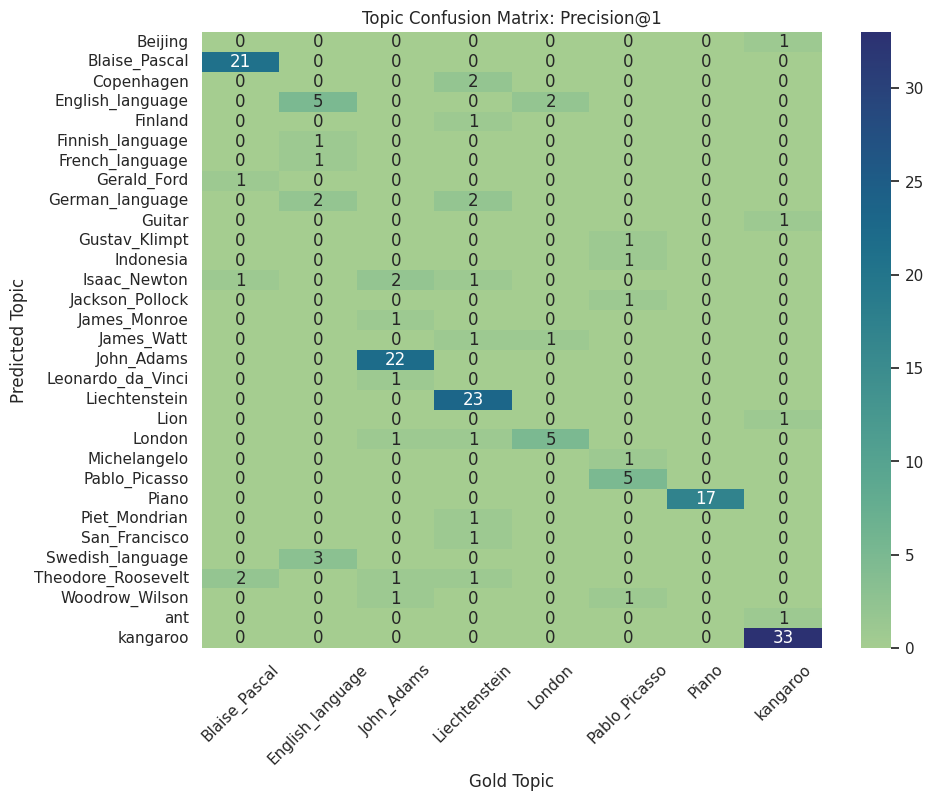

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

sns.set_theme()

plot_df = pd.read_csv('RAG_Results_clean.csv')

y_pred = plot_df.get('Predicted Topic')
y_true = plot_df.get('Gold Topic')

total_files = pd.concat([y_pred, y_true])

labels = list(set(total_files))

#cm_files = confusion_matrix(y_true, y_pred, labels = labels)
#sns.heatmap(cm_files)

# Create contingency table
conf_matrix = pd.crosstab(plot_df['Predicted Topic'], plot_df['Gold Topic'])

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="crest")   #cmap="crest"
plt.title("Topic Confusion Matrix: Precision@1")
plt.xlabel("Gold Topic")
plt.xticks(rotation=45)
plt.ylabel("Predicted Topic")
plt.show()

#glue = plot_df.pivot(index="Cleaned Retrieval", columns="Gold file", values="Retreival accuracy")
#sns.heatmap(glue)


# Draw a heatmap with the numeric values in each cell
#f, ax = plt.subplots(figsize=(9, 6))
#sns.heatmap(plot_df, annot=True, fmt="d", linewidths=.5, ax=ax)

In [ ]:
#from InstructScore import *

ModuleNotFoundError: No module named 'InstructScore'

In [ ]:
""" Running a chat with the questions as input each time """

def chat(query):
        
        #Initialize a conversation-template as memory
        conversation = [
        {
            "role": "system",
            "content": " "
        }]

        print(f'Question: {query}')
        results = search_db(query)
        
        # Update system message with new context on each turn
        context_text = "\n\n---\n\n".join([content for content in results.get('documents')[0]])
        conversation[0]["content"] = f"{context_text}"

        # Append user message
        conversation.append({"role": "user", "content": query})

        # Generate
        prompt = create_prompt(results, query)
        #print(f'Prompt: {prompt}')
        answer = generate_response(prompt)
        print(f'Answer: {answer}')

        conversation.append({"role": "system", "content": answer})
        return answer

#chat()